In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import datetime
import torch
from torch.nn import functional as F
import scipy.stats
import sklearn.datasets

import sys
sys.path.append("../")
import curvvae_lib.train.predictive_passthrough_trainer as ppttrainer
import curvvae_lib.architecture.passthrough_vae as ptvae
import curvvae_lib.architecture.save_model as sm
import curvvae_lib.architecture.load_model as lm

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-dprpzcdm because the default path (/home/tsr42/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Dataset

In [2]:
foodname = "banana"
foldername = f"fork_trajectory_{foodname}"
savefilename = f"{foodname}_clean_pickups"

In [3]:
train = []
training_ts = np.linspace(0,1,64)
attempt = 1
while True:
    try:
        raw_vals = np.load(f"{savefilename}/pickup_attempt{attempt}.npy")
        train.append(raw_vals.T.flatten())
    except:
        print(f"We found {attempt-1} pickup attempts")
        break
    attempt += 1

train = np.array(train).reshape(-1,7,64)
all_points = train[:,:,:]

time_shape = list(all_points.shape)
time_shape[1] = 1
# why be smart when you can be dumb
t = np.ones(time_shape)
for i in range(time_shape[2]):
    t[:,:,i] = t[:,:,i] * i / (time_shape[2] + 0.0)

all_points = np.concatenate((t, all_points), axis=1)
all_points = all_points.transpose(0,2,1)
# actually this is all points, not just start points
start_points = all_points[:,:,1:].reshape(-1,7)
print("start_points_shape", start_points.shape)
# See http://localhost:8889/notebooks/scratchwork/2021-09-17%20Rotation%20Scaling.ipynb
# for why we want quaternion values to be multiplied by 0.16 when position values are in meters 
# (if the relevant distance scale of the fork is 0.08 meters, ie: 8cm).
mean = np.mean(start_points, axis=0)
variance = np.var(start_points, axis=0)
position_std = np.sqrt(np.max(variance))
print("std of: ", position_std)
position_scaling = 1/position_std
rotation_scaling = 0.16 * position_scaling

start_points = start_points - mean
poss = position_scaling
rts = rotation_scaling
start_points = (start_points * np.array((poss,poss,poss,rts,rts,rts,rts)))
#start_points = start_points[:,3:]
print("shape before reducing dimension", all_points.shape)
print("dataset variance of:", np.var(start_points,axis=0))

We found 155 pickup attempts
start_points_shape (9920, 7)
std of:  0.17859106200728153
shape before reducing dimension (155, 64, 8)
dataset variance of: [0.00082463 0.00106736 0.00316102 0.00634536 0.0256     0.00564557
 0.00894256]


In [4]:
dataset = start_points
dataset

array([[ 5.30630546e-02, -7.39897730e-02,  6.99848376e-02, ...,
         5.77279855e-02,  3.91912119e-02,  2.56211944e-02],
       [ 4.82265267e-02, -6.74389532e-02,  6.44204345e-02, ...,
         5.95007100e-02,  3.93298113e-02,  2.38431718e-02],
       [ 4.42146147e-02, -6.03095820e-02,  5.96689720e-02, ...,
         6.08009003e-02,  3.93789762e-02,  2.20194015e-02],
       ...,
       [-9.03704476e-03,  1.13378370e-01,  8.72505381e-02, ...,
        -7.04652473e-02, -2.69143945e-02, -1.99310649e-01],
       [-2.72879079e-03,  1.19000039e-01,  1.06496165e-01, ...,
        -9.01796312e-02, -2.89765200e-02, -2.14355879e-01],
       [-1.67703832e-05,  1.42264068e-01,  1.38627073e-01, ...,
        -1.05488737e-01, -2.73580771e-02, -2.35037893e-01]])

In [5]:
np.random.seed(1)
train_indices = np.random.choice(len(dataset),100,replace=False)
test_indices = [i for i in range(len(dataset)) if i not in train_indices]
train_dataset=dataset[train_indices]
test_dataset=dataset[test_indices]
print(train_dataset.shape,test_dataset.shape)

(100, 7) (9820, 7)


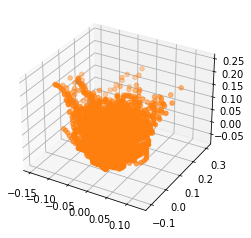

In [6]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(train_dataset[:,0],train_dataset[:,1],train_dataset[:,2]);
ax.scatter(test_dataset[:,0],test_dataset[:,1],test_dataset[:,2]);

In [7]:
#fig = plt.figure()
#ax = plt.axes(projection='3d')
#ax.scatter(train_dataset[:,3],train_dataset[:,4],train_dataset[:,5]);
#ax.scatter(test_dataset[:,3],test_dataset[:,4],test_dataset[:,5]);

## 2D VAE Fit to Dataset

In [8]:
def LoadDataBatch(all_points, batchsize, passthroughdim, predictive, device):
    """Sample Pair of Points from Trajectory"""
    # all_points should be of dimension: num_trajectories, numtimesteps, 1+spatialdims
    traj_ids = np.random.choice(all_points.shape[0], batchsize)
    t1_ids = np.random.choice(all_points.shape[1], batchsize)
    if predictive:
        t2_ids = np.random.choice(all_points.shape[1], batchsize)
    else:
        t2_ids = t1_ids
    return (torch.tensor(all_points[traj_ids, t1_ids,passthroughdim:], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t1_ids,:passthroughdim], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t2_ids,passthroughdim:], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t2_ids,:passthroughdim], dtype=torch.float).to(device))

In [9]:
class Loader(object):
    def __init__(self, all_points, batchsize, passthroughdim, epochnumbatches, predictive, device):
        self.all_points = all_points
        self.batchsize = batchsize
        self.passthroughdim = passthroughdim
        self.epochnumbatches = epochnumbatches
        self.predictive = predictive
        self.device = device
        
    def __iter__(self):
        self.n = 0
        return self
    
    def __next__(self):
        if self.n >= self.epochnumbatches:
            # https://docs.python.org/3/library/exceptions.html#StopIteration
            raise StopIteration
        self.n += 1
        return LoadDataBatch(self.all_points, self.batchsize, self.passthroughdim, self.predictive, self.device)
    

device = "cuda"
  

In [10]:
dataset_dim = dataset.shape[-1]
def make_vae(latent_dim):
    input_dim = dataset_dim 
    passthrough_dim = 0
    emb_layer_widths = [1000]
    recon_layer_widths = [1000]
    dtype = torch.float
    model = ptvae.FCPassthroughVAE(input_dim, passthrough_dim, latent_dim,
        emb_layer_widths, recon_layer_widths, dtype)
    return model

In [11]:
def error(vae, dataset):
    embeds = vae.encode(torch.tensor(dataset,dtype=torch.float).to(device),
                       torch.tensor(np.zeros((len(dataset),0)),dtype=torch.float).to(device)
                       )[0].detach().cpu().numpy()
    recons = vae.decode(torch.tensor(embeds,dtype=torch.float).to(device),
              torch.tensor(np.zeros((len(embeds),0)),dtype=torch.float).to(device))[0].detach().cpu()
    rmse = np.sqrt(np.mean(np.sum(np.square(dataset - recons.numpy()),axis=1)))
    return rmse

In [12]:
# train a CurvVAE model with given beta and gamma and return
# the string name of the saved model
def train_vae_model(beta,gamma,lr,epochs,latentdim,testname,train_dataset,test_dataset,device="cpu"):
    vae = make_vae(latent_dim=latentdim).to(device)
    num_epochs = epochs
    epsilon_scale_start = 0.5
    epsilon_scale = epsilon_scale_start
    savedir  = f'{testname}lat{latentdim}_lr{lr}_gamma{gamma}_es{epsilon_scale_start}_beta{beta}_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'
    print(savedir)
    train_loader = Loader(train_dataset[:,np.newaxis,:], 256, 0,10,predictive=False, device=device)
    trainer = ppttrainer.PPTVAETrainer(vae, train_loader, beta=beta, device=device,
        log_dir=savedir, lr=lr, annealingBatches=0, record_loss_every=200, loss_func = "gaussian")
    epoch = 0
    traintesterrors = []
    for _ in range(num_epochs*3):
        epoch+=1
        # up num sample points to reduce variance of curvature measure
        embst = trainer.train(second_deriv_regularizer=secreg, curvature_regularizer=gamma, epsilon_scale = epsilon_scale, num_new_samp_points=512)
        is_error = embst[0]
        if is_error:
            raise Exception
        if epoch % 10 == 0:
            traintesterrors.append((epoch,error(vae,train_dataset),error(vae,test_dataset)))
    sm.save_fcpassthrough_vae(vae, savedir)
    print(savedir)
    return savedir,traintesterrors

In [13]:
test_dataset.shape

(9820, 7)

In [14]:
dat = np.load("200samples_20220721-022557.npz")
all_models = dat["all_models"]
all_traintesterrors = dat["all_traintesterrors"]

In [15]:
#savedirs = [
#"overfitting/testcodelat2_lr0.0001_gamma0_es1.0_beta1e-05_20220714-180311",
#"overfitting/testcodelat2_lr0.0001_gamma0.001_es1.0_beta1e-05_20220714-180335",
#"overfitting/testcodelat2_lr0.0001_gamma1_es1.0_beta1e-05_20220714-180359",
#"overfitting/testcodelat2_lr0.0001_gamma0_es1.0_beta0.001_20220714-180422",
#"overfitting/testcodelat2_lr0.0001_gamma0.001_es1.0_beta0.001_20220714-180447",
#"overfitting/testcodelat2_lr0.0001_gamma1_es1.0_beta0.001_20220714-180510",
#"overfitting/testcodelat2_lr0.0001_gamma0_es1.0_beta1.0_20220714-180535",
#"overfitting/testcodelat2_lr0.0001_gamma0.001_es1.0_beta1.0_20220714-180558",
#"overfitting/testcodelat2_lr0.0001_gamma1_es1.0_beta1.0_20220714-180621"
#]

In [16]:
all_traintesterrors

array([[[1.00000000e+01, 2.25311368e-01, 2.35529558e-01],
        [2.00000000e+01, 2.19349378e-01, 2.29220303e-01],
        [3.00000000e+01, 2.18582264e-01, 2.28719056e-01],
        ...,
        [2.38000000e+03, 6.76142621e-02, 6.89653601e-02],
        [2.39000000e+03, 6.77949599e-02, 7.00899626e-02],
        [2.40000000e+03, 6.74121683e-02, 6.94437242e-02]],

       [[1.00000000e+01, 2.25620827e-01, 2.37004229e-01],
        [2.00000000e+01, 2.17522486e-01, 2.29517640e-01],
        [3.00000000e+01, 2.16142032e-01, 2.26270874e-01],
        ...,
        [2.38000000e+03, 2.20243172e-02, 6.92721937e-02],
        [2.39000000e+03, 2.17792633e-02, 6.92525685e-02],
        [2.40000000e+03, 2.22955642e-02, 6.94465188e-02]],

       [[1.00000000e+01, 2.27381068e-01, 2.38690075e-01],
        [2.00000000e+01, 2.23923664e-01, 2.35036710e-01],
        [3.00000000e+01, 2.22148908e-01, 2.33539093e-01],
        ...,
        [2.38000000e+03, 2.71924814e-02, 7.56396793e-02],
        [2.39000000e+03, 2.66

In [17]:
[am[3] for am in all_models]

['5e-05',
 '5e-05',
 '5e-05',
 '5e-05',
 '5e-05',
 '5e-05',
 '5e-05',
 '5e-05',
 '5e-05',
 '5e-05',
 '5e-05',
 '5e-05',
 '5e-05',
 '5e-05',
 '5e-05',
 '5e-05',
 '5e-05',
 '5e-05',
 '5e-05',
 '5e-05',
 '5e-05',
 '5e-05',
 '5e-05',
 '5e-05',
 '5e-05',
 '5e-05',
 '5e-05',
 '5e-05',
 '5e-05',
 '0.0001',
 '0.0001',
 '0.0001',
 '0.0001',
 '0.0001',
 '0.0001',
 '0.0001',
 '0.0001',
 '0.0001',
 '0.0001',
 '0.0001',
 '0.0001',
 '0.0001',
 '0.0001',
 '0.0001',
 '0.0001',
 '0.0001',
 '0.0001',
 '0.0001',
 '0.0001',
 '0.0001',
 '0.0001',
 '0.0001',
 '0.0001',
 '0.0001',
 '0.0001',
 '0.0001',
 '0.0001',
 '0.0001',
 '1e-05',
 '1e-05',
 '1e-05',
 '1e-05',
 '1e-05',
 '1e-05',
 '1e-05',
 '1e-05',
 '1e-05',
 '1e-05',
 '1e-05',
 '1e-05',
 '1e-05',
 '1e-05',
 '1e-05',
 '1e-05',
 '1e-05',
 '1e-05',
 '1e-05',
 '1e-05',
 '1e-05',
 '1e-05',
 '1e-05',
 '1e-05',
 '1e-05',
 '1e-05',
 '1e-05',
 '1e-05',
 '1e-05',
 '5e-05',
 '5e-05',
 '5e-05',
 '5e-05',
 '5e-05',
 '5e-05',
 '5e-05',
 '5e-05',
 '5e-05',
 '5e-05',
 

In [18]:
len(all_models)

870

In [19]:
import matplotlib
font = {'size'   : 22}
matplotlib.rc('font', **font)

In [20]:
finalfitdataset_beta = []
finalfitdataset_curv = []
for i,dat in enumerate(all_traintesterrors):
    (beta,gamma,latentdim,lr,savedir)=all_models[i]
    dat = np.array(dat)
    okinds = np.arange(len(dat)) > (len(dat)-2) # (dat[:,1] < 0.3) * 
    train = dat[okinds,1]
    test = dat[okinds,2]
    #if lr == "0.0001" or lr == "5e-05":
    #    continue
    print(beta)
    if gamma == "0":
        finalfitdataset_beta.append((train,test))
    else:
        finalfitdataset_curv.append((train,test))
finalfitdataset_beta = np.array(finalfitdataset_beta)
finalfitdataset_curv = np.array(finalfitdataset_curv)

1e-05
1e-05
0.001
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
0.0001
0.002
0.003
0.005
0.007
0.01
0.02
0.04
0.1
1.0
1e-05
1e-05
1e-05
1e-05
0.001
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
0.0001
0.002
0.003
0.005
0.007
0.01
0.02
0.04
0.1
1.0
1e-05
1e-05
1e-05
1e-05
0.001
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
0.0001
0.002
0.003
0.005
0.007
0.01
0.02
0.04
0.1
1.0
1e-05
1e-05
1e-05
1e-05
0.001
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
0.0001
0.002
0.003
0.005
0.007
0.01
0.02
0.04
0.1
1.0
1e-05
1e-05
1e-05
1e-05
0.001
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
0.0001
0.002
0.003
0.005
0.007
0.01
0.02
0.04
0.1
1.0
1e-05
1e-05
1e-05
1e-05
0.001
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
0.0001
0.002
0.003
0.005
0.007
0.01
0.02
0.04
0.1
1.0
1e-0

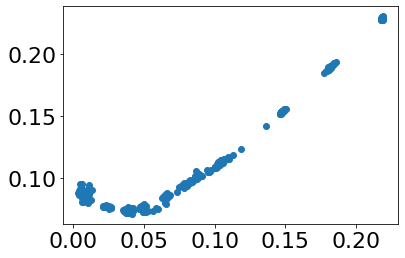

In [21]:
plt.scatter(finalfitdataset_beta[:,0],finalfitdataset_beta[:,1])

In [22]:
finalfitdataset_beta[:].shape

(390, 2, 1)

In [23]:
X_train = finalfitdataset_beta[:,0]
y_train = finalfitdataset_beta[:,1,0]

In [24]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(
    noise_level=1e-1, noise_level_bounds=(1e-6, 1e1)
)
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha=0)
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_

0.122**2 * RBF(length_scale=0.0586) + WhiteKernel(noise_level=3.14e-06)

In [25]:
X = np.arange(0,0.25,0.001).reshape(-1,1)
y_mean, y_std = gaussian_process.predict(X, return_std=True)

In [26]:
fitmodels = []
for (label, color, errorcolor, X_train, y_train) in [
        ("BetaVAE", "red" , "tab:orange" , finalfitdataset_beta[:,0], finalfitdataset_beta[:,1,0]),
        ("CurvVAE", "k"   , "tab:blue"   , finalfitdataset_curv[:,0], finalfitdataset_curv[:,1,0])
    ]:
    kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(
        noise_level=1e-1, noise_level_bounds=(1e-6, 1e1)
    )
    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha=0)
    gaussian_process.fit(X_train, y_train)
    fitmodels.append(gaussian_process)

In [27]:
import statsmodels

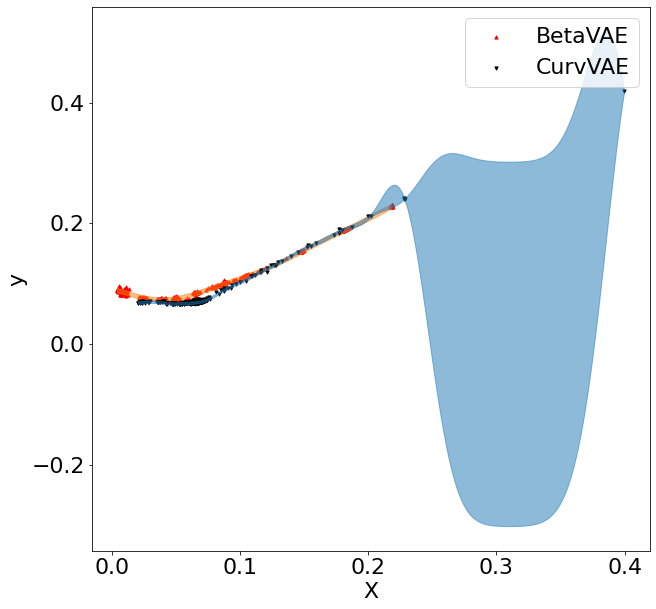

In [28]:

plt.figure(figsize=(10,10))
for (label, color, errorcolor, X_train, y_train, gaussian_process, marker) in [
        ("BetaVAE", "red" , "tab:orange" , finalfitdataset_beta[:,0], finalfitdataset_beta[:,1,0], fitmodels[0], "^"),
        ("CurvVAE", "k"   , "tab:blue"   , finalfitdataset_curv[:,0], finalfitdataset_curv[:,1,0], fitmodels[1], "v")
    ]:
    X = np.arange(np.min(X_train),np.max(X_train),0.001).reshape(-1,1)
    plt.scatter(x=X_train[:, 0], y=y_train, color=color, label=label,s=10, marker = marker)
    #plt.errorbar(X, y_mean, y_std*2)
    y_mean, y_std = gaussian_process.predict(X, return_std=True)
    plt.fill_between(
        X.ravel(),
        y_mean - 1.96 * y_std,
        y_mean + 1.96 * y_std,
        color=errorcolor,
        alpha=0.5,
        #label=r"95% confidence interval",
    )
    plt.legend()
    plt.xlabel("X")
    plt.ylabel("y")


In [29]:
import lowess

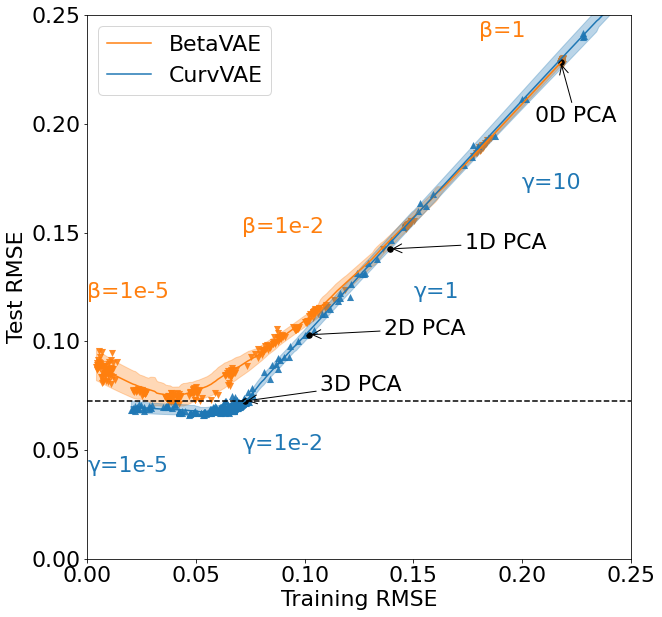

In [40]:
f,ax = plt.subplots(1,1,figsize=(10,10))
for (label, color, errorcolor, X_train, y_train, gaussian_process, marker) in [
        ("BetaVAE", "tab:orange" , "tab:orange" , finalfitdataset_beta[:,0], finalfitdataset_beta[:,1,0], fitmodels[0], "v"),
        ("CurvVAE", "tab:blue"   , "tab:blue"   , finalfitdataset_curv[:,0], finalfitdataset_curv[:,1,0], fitmodels[1], "^")
    ]:
    X = np.arange(np.min(X_train),np.max(X_train),0.001).reshape(-1,1)
    #X = np.arange(0,0.25,0.001).reshape(-1,1)
    plt.scatter(x=X_train[:, 0], y=y_train, color=color,s=50, marker = marker,#, label=label
                alpha=0.9,linewidths=0,edgecolors=None)
    y_mean,y_std,y_point_std = lowess.fit_1d_lowess_with_confidence_bounds(X_train,y_train, X,0.25)
    plt.fill_between(
        X.ravel(),
        y_mean - 1.96 * (y_std + y_point_std),
        y_mean + 1.96 * (y_std + y_point_std),
        color=errorcolor,
        alpha=0.3,
        #label=r"95% confidence interval",
    )
    plt.plot(
        X.ravel(),
        y_mean,
        color=errorcolor,
        alpha=1,
        label=label,
    )
pcatraintestresults = [
(0.21781233735443287, 0.22829858320432667),
(0.13923331571589267, 0.14249965880865273),
(0.10203240379282046, 0.10303908873477717),
(0.07265237510683954, 0.07256255472422367)]
for i, (pcatrain, pcatest) in enumerate(pcatraintestresults):
    plt.scatter(pcatrain,pcatest,s=30,c="k")
    if i == 0:
        plt.annotate(f"{i}D PCA",(pcatrain,pcatest),
                     xytext=(-26, -60), textcoords='offset points', color="k",
                     arrowprops=dict(arrowstyle="->", color="k"))
    elif i == 3:
        plt.annotate(f"{i}D PCA",(pcatrain,pcatest),
                     xytext=(75, 10), textcoords='offset points', color="k",
                     arrowprops=dict(arrowstyle="->", color="k"))
    else:
        plt.annotate(f"{i}D PCA",(pcatrain,pcatest),
                     xytext=(75, 0), textcoords='offset points', color="k",
                     arrowprops=dict(arrowstyle="->", color="k"))
plt.plot((0,0.25),(pcatraintestresults[-1][1],pcatraintestresults[-1][1]),color="k",linestyle="--")
plt.annotate(f"β=1",(0.18, 0.24),color="tab:orange")
plt.annotate(f"β=1e-5",(0.0, 0.12),color="tab:orange")
plt.annotate(f"β=1e-2",(0.09, 0.15),color="tab:orange",horizontalalignment="center")
plt.annotate(f"γ=10",(0.20, 0.17),color="tab:blue")
plt.annotate(f"γ=1",(0.15, 0.12),color="tab:blue")
plt.annotate(f"γ=1e-5",(0.0, 0.04),color="tab:blue")
plt.annotate(f"γ=1e-2",(0.09, 0.05),color="tab:blue",horizontalalignment="center")
ax.set_aspect("equal","box")
plt.xlim(0,0.25)
plt.ylim(0,0.25)
plt.xticks(np.arange(0, 0.26, step=0.05))
plt.yticks(np.arange(0, 0.26, step=0.05))
plt.xlabel("Training RMSE")
plt.ylabel("Test RMSE")
plt.legend()
plt.savefig("TrainingTestError200TrainingPoints.png",bbox_inches="tight")

In [31]:
print(len(finalfitdataset_beta)/30)
print(len(finalfitdataset_curv)/30)
print(len(finalfitdataset_beta))
print(len(finalfitdataset_curv))

13.0
16.0
390
480


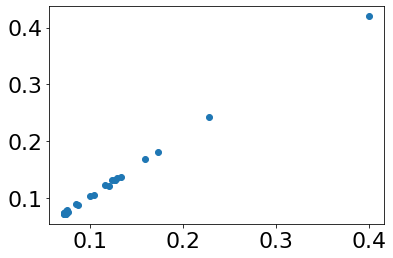

In [37]:
labelcheck = []
for i,dat in enumerate(all_traintesterrors):
    (beta,gamma,latentdim,lr,savedir)=all_models[i]
    dat = np.array(dat)
    okinds = np.arange(len(dat)) > (len(dat)-2) # (dat[:,1] < 0.3) * 
    train = dat[okinds,1]
    test = dat[okinds,2]
    #if lr == "0.0001" or lr == "5e-05":
    #    continue
    #print(beta)
    if gamma == "1.0":
        labelcheck.append((train,test))
labelcheck = np.array(labelcheck)
plt.scatter(labelcheck[:,0], labelcheck[:,1])

In [33]:
xplotvals =
mean_prediction, std_prediction = gaussian_process.predict(xplotvals, return_std=True)
print(mean_prediction.shape, std_prediction.shape)

SyntaxError: invalid syntax (<ipython-input-33-5a8b89c000f0>, line 1)

In [ ]:
std_prediction

In [ ]:

plt.figure(figsize=(10,10))
plt.scatter(finalfitdataset_beta[:,0], finalfitdataset_beta[:,1], label="Observations")
plt.scatter(xplotvals, mean_prediction, label="Mean prediction")
plt.fill_between(
    xplotvals.flatten(),
    (mean_prediction.flatten() - 1.96 * std_prediction.flatten()).flatten(),
    (mean_prediction.flatten() + 1.96 * std_prediction.flatten()).flatten(),
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("train error")
plt.ylabel("test error")
_ = plt.title("Gaussian process regression on beta fits")

In [ ]:
f,ax = plt.subplots(1,1,figsize=(10,10))
numpointstotal = 0
for i,dat in enumerate(all_traintesterrors):
    (beta,gamma,latentdim,lr,savedir)=all_models[i]
    label="b%s_g%s" % (beta,gamma)
    dat = np.array(dat)
    okinds = np.arange(len(dat)) > (len(dat)-2) # (dat[:,1] < 0.3) * 
    train = dat[okinds,1]
    test = dat[okinds,2]
    #if lr == "0.0001" or lr == "5e-05":
    #    continue
    
    if gamma == "0":
        plt.scatter(train,test,label=label,s=5,c="red")
    #elif gamma == "0.1":
    #    plt.scatter(train,test,label=label,s=3,c="blue")
    else:
        plt.scatter(train,test,label=label,s=5,c="k")
    numpointstotal+=1
print(numpointstotal)
#plt.xlim(0,0.25)
#plt.ylim(0,0.25)
#plt.plot([0,0.25],[0,0.25],linestyle="--")
pcatraintestresults = [
(0.22419371587397705, 0.2280505547284446),
(0.14522424739834378, 0.14321458052304378),
(0.10528128829504901, 0.10464429348233918),
(0.07626925807955225, 0.07492719427840255)]
for pcatrain, pcatest in pcatraintestresults:
    plt.scatter(pcatrain,pcatest,s=30,c="blue")
plt.plot((0.0,0.25),(pcatraintestresults[3][1],pcatraintestresults[3][1]),linestyle="--")
#plt.legend()
ax.set_aspect("equal","box")
plt.xlim(0,0.25)
plt.ylim(0,0.25)
plt.xticks(np.arange(0, 0.26, step=0.05))
plt.yticks(np.arange(0, 0.26, step=0.05))
plt.xlabel("Training RMSE")
plt.ylabel("Test RMSE")
plt.show()
#plt.savefig("FittingAllPosesTrainSize100.png")